## <font color=darkolivegreen> Аналитика в Яндекс.Афише </font> 

Заказчик - отдел аналитики Яндекс.Афиши. Необходимо помочь маркетологам оптимизировать маркетинговые затраты: разработать рекомендации маркетологам 
 - куда и сколько им стоит вкладывать денег?
 - какие источники/платформы использовать?

## <font color=olive>Описание данных</font>

#### <font color=olivedrab>Таблица visits (лог сервера с информацией о посещениях сайта):</font>
 - Uid — уникальный идентификатор пользователя;
 - Device — категория устройства пользователя;
 - Start Ts — дата и время начала сессии;
 - End Ts — дата и время окончания сессии;
 - Source Id — идентификатор рекламного источника, из которого пришел пользователь.
 
#### <font color=olivedrab>Таблица orders (информация о заказах):</font> 
 - Uid — уникальный id пользователя, который сделал заказ;
 - Buy Ts — дата и время заказа;
 - Revenue — выручка Яндекс.Афиши с этого заказа.
 
 
#### <font color=olivedrab>Таблица costs (информация о затратах на маркетинг):</font>  
 - source_id — идентификатор рекламного источника;
 - dt — дата;
 - costs — затраты на этот рекламный источник в этот день.


### <font color=olive>Шаг 1. Загрузка данных</font>

In [1]:
# импортируем данные
import pandas as pd
from datetime import datetime, time
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# и сохраним исходные таблицы в переменных:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

In [3]:
# посмотрим информацию по каждой из таблиц:
for data in [visits, orders, costs]: 
    print(data.info(), end='\n\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB
None



В таблице visits (лог сервера с информацией о посещениях сайта) представлена информация о 359 400 посещениях. Все столбцы полностью заполнены. У столбцов Start Ts — дата и время начала сессии, и End Ts — дата и время окончания сессии, неверно представлен тип данных.

В таблице orders (информация о заказах) представлена информация о 50 415 заказах. Все столбцы полностью заполнены. У столбца Buy Ts — дата и время заказа, - неверно представлен тип данных.

В таблице costs (информация о затратах на маркетинг) представлена информация 2 542 случаях расходов на маркетинг. Все столбцы полностью заполнены. У столбца dt — дата, - неверно представлен тип данных.

In [4]:
# заменим тип данных object столбцов Start Ts и End Ts таблицы visits, Buy Ts таблицы orders и dt таблицы costs на дату:
visits['End Ts'] = pd.to_datetime(visits['End Ts'])
visits['Start Ts'] = pd.to_datetime(visits['Start Ts'])
orders['Buy Ts'] = pd.to_datetime(orders['Buy Ts'])
costs['dt'] = pd.to_datetime(costs['dt'])

In [5]:
# заменим названия столбцов в таблицах
visits.set_axis(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], axis = 'columns', inplace = True)
orders.set_axis(['buy_ts', 'revenue', 'uid'], axis = 'columns', inplace = True)
costs.set_axis(['source_id', 'acquisition_date', 'costs'], axis = 'columns', inplace = True)

In [6]:
# удалим строку в таблице orders с датой заказа 01.06.2018 года, т.к. она вне анализируемого периода
orders.drop([50414], inplace=True)

In [7]:
# посчитаем дублирующие строки в каждой из таблиц
for data in [visits, orders, costs]: 
    print(data.duplicated().sum(), end='\n\n')

0

0

0



### <font color=olive>Шаг 2. Постройте отчёты и посчитайте метрики</font>

#### <font color=olivedrab>Продукт</font> 

Посчитаем сколько людей пользуются в день, неделю, месяц:
- DAU (от англ. daily active users) — количество уникальных пользователей в день;
- WAU (от англ. weekly active users) — количество уникальных пользователей в неделю;
- MAU (от англ. monthly active users) — количество уникальных пользователей в месяц.

In [8]:
visits['session_date'] = visits['start_ts'].dt.date
visits['session_year'] = visits['start_ts'].astype('datetime64[Y]')
visits['session_month'] = visits['start_ts'].astype('datetime64[M]')
visits['session_week'] = visits['start_ts'].astype('datetime64[W]')

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


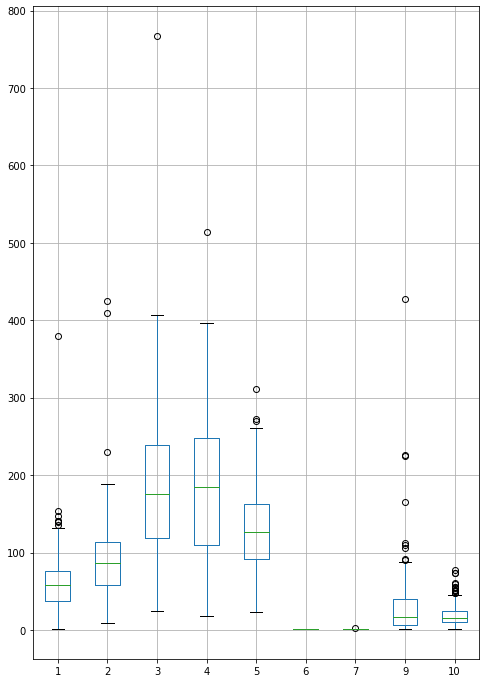

In [9]:
# посчитаем количество уникальных пользователей в день DAU по устройствам и по источникам привлечения пользователей:
# количество уникаольных пользователей в день для desktop-устройств:

visits_desktop_pivot_by_date = visits.query('device == "desktop"').pivot_table(index=['session_date'],
                                                                       columns = 'source_id',
                                                                       values='uid', aggfunc='nunique').reset_index()
# количество уникальных пользователей в день для touch-устройств:
visits_touch_pivot_by_date = visits.query('device == "touch"').pivot_table(index=['session_date'],
                                                                   columns = 'source_id',
                                                                   values='uid', aggfunc='nunique').reset_index()

# для их сравнения между собой построим ящики с усами для каждого устройства с разбивкой по источникам привлечения:
visits_desktop_pivot_by_date.boxplot(figsize = (8, 12));

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


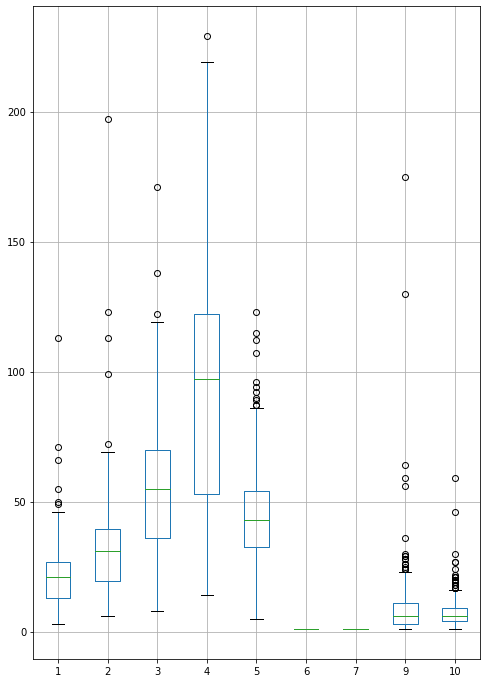

In [10]:
visits_touch_pivot_by_date.boxplot(figsize = (8, 12));

In [11]:
# количество уникальных пользователей desktop-устройств в день:
int(visits.query('device == "desktop"').groupby('session_date').agg({'uid': 'nunique'}).mean())

659

In [12]:
# количество уникальных пользователей touch-устройств в день:
int(visits.query('device == "touch"').groupby('session_date').agg({'uid': 'nunique'}).mean())

252

Как видно из графиков, количество уникальных пользователей desktop-устройств больше, чем пользователей touch-устройств. Это подтверждают и расчеты, с desktop-устройств заходят в среднем 659 человек, а с touch-устройств - 252. При этом четвертый вариант привлечения  пользователей для обоих типов устройств наиболее действенный, в то время как шестой и седьмой вариант привлечения пользователей наименее действенный.

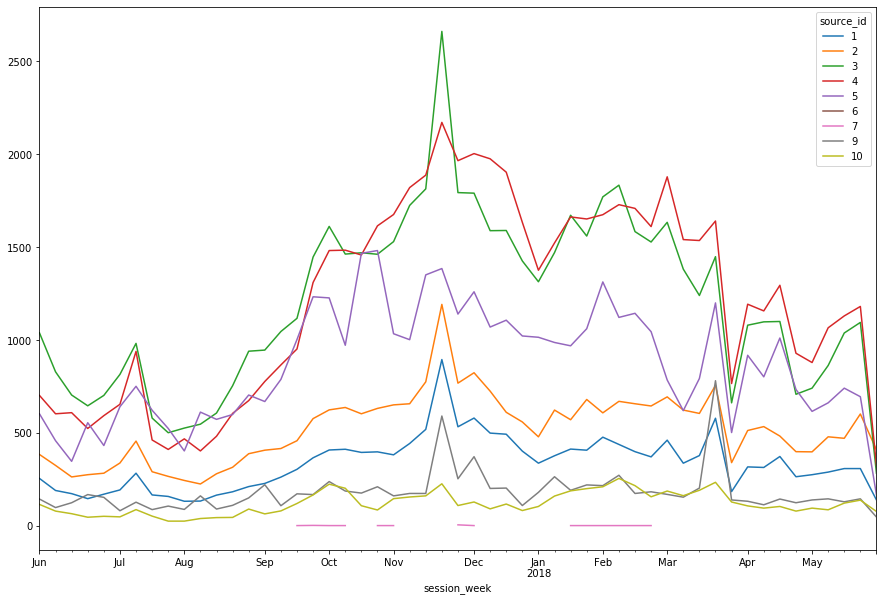

In [13]:
# посчитаем количество уникальных пользователей в неделю WAU по устройствам и по источникам привлечения пользователей:

# количество уникаольных пользователей в неделю для desktop-устройств:
visits_desctop_pivot_by_week = visits.query('device == "desktop"').pivot_table(index=['session_week'],
                                                                       columns = 'source_id',
                                                                       values='uid', aggfunc='nunique').reset_index()

# количество уникальных пользователей в неделю для touch-устройств:
visits_touch_pivot_by_week = visits.query('device == "touch"').pivot_table(index=['session_week'],
                                                                   columns = 'source_id',
                                                                   values='uid', aggfunc='nunique').reset_index()

visits_desctop_pivot_by_week.plot(x = 'session_week', figsize=(15, 10));

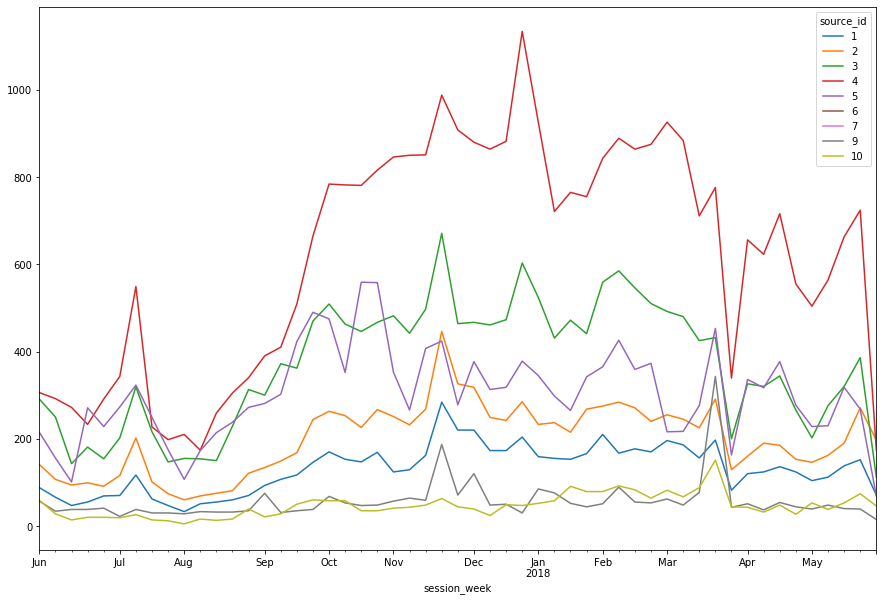

In [14]:
visits_touch_pivot_by_week.plot(x = 'session_week', figsize=(15, 10));

In [15]:
# количество уникальных пользователей desktop-устройств в неделю:
int(visits.query('device == "desktop"').groupby(['session_year', 'session_week']).agg({'uid': 'nunique'}).mean())

4061

In [16]:
# количество уникальных пользователей touch-устройств в неделю:
int(visits.query('device == "touch"').groupby(['session_year', 'session_week']).agg({'uid': 'nunique'}).mean())

1607

В укрупненных до 1 недели графиках и расчетах ситуация аналогичная, количество уникальных пользователей desktop-устройств (4 129) больше, чем пользователей touch-устройств (1 634).

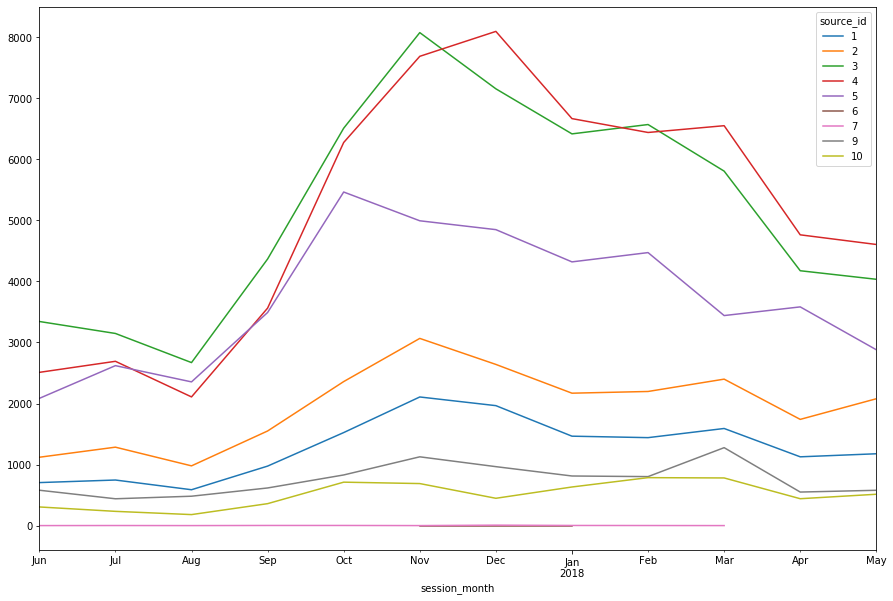

In [17]:
# посчитаем количество уникальных пользователей в месяц MAU по устройствам и по источникам привлечения пользователей:

# количество уникальных пользователей в месяц для desktop-устройств:
visits_desktop_pivot_by_month = visits.query('device == "desktop"').pivot_table(index=['session_month'],
                                                                       columns = 'source_id',
                                                                       values='uid', aggfunc='nunique').reset_index()

# количество уникальных пользователей в месяц для touch-устройств:
visits_touch_pivot_by_month = visits.query('device == "touch"').pivot_table(index=['session_month'],
                                                                   columns = 'source_id',
                                                                   values='uid', aggfunc='nunique').reset_index()

visits_desktop_pivot_by_month.plot(x = 'session_month', figsize=(15, 10));

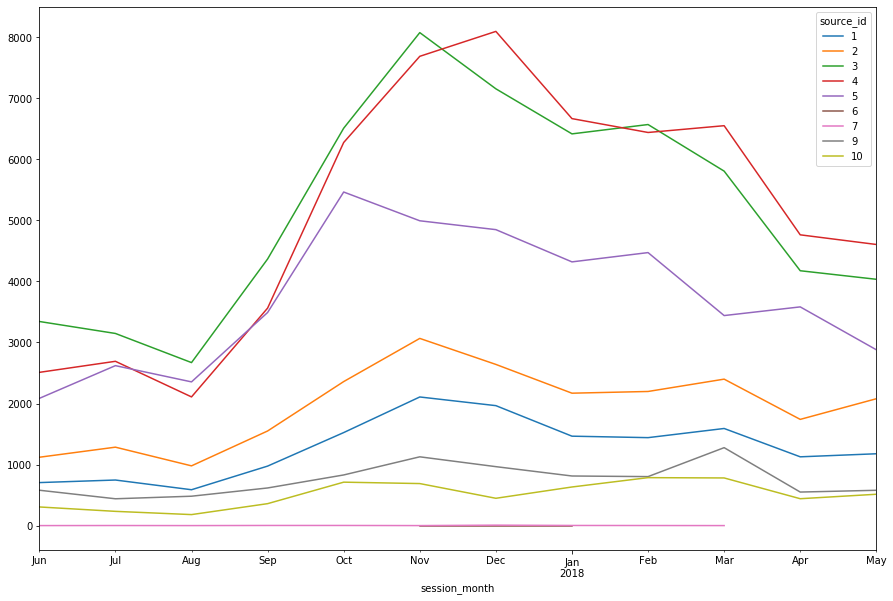

In [18]:
visits_desktop_pivot_by_month.plot(x = 'session_month', figsize=(15, 10));

In [21]:
# количество уникальных пользователей desktop-устройств в месяц:
int(visits.query('device == "desktop"').groupby(['session_year', 'session_month']).agg({'uid': 'nunique'}).mean())

16724

In [22]:
# количество уникальных пользователей touch-устройств в месяц:
int(visits.query('device == "touch"').groupby(['session_year', 'session_month']).agg({'uid': 'nunique'}).mean())

6825

Количество уникальных пользователей desktop-устройств в месяц 16 724, touch-устройств - 6 825. Пользователей touch-устройств в 2,5 раза меньше, чем пользователей desktop-устройств.

Посчитаем сколько сессий в день и сколько длится одна сессия для каждого типа устройства.

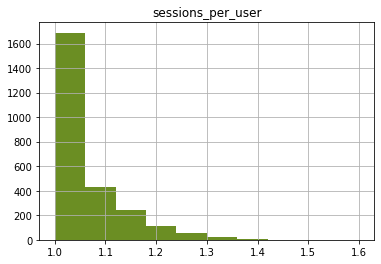

In [23]:
# количество сессий в день пользователей desktop-устройств:
sessions_per_user_desktop = visits.query('device == "desktop"').groupby(['source_id','session_date']).agg({'uid': ['count','nunique']})
sessions_per_user_desktop
# количество сессий в день пользователей touch-устройств:
sessions_per_user_touch = visits.query('device == "touch"').groupby('session_date').agg({'uid': ['count','nunique']})

for data in [sessions_per_user_desktop, sessions_per_user_touch]: 
    data.columns = ['n_sessions', 'n_users']
    data['sessions_per_user'] = data['n_sessions'] / data['n_users']
sessions_per_user_desktop.hist('sessions_per_user', color="olivedrab");

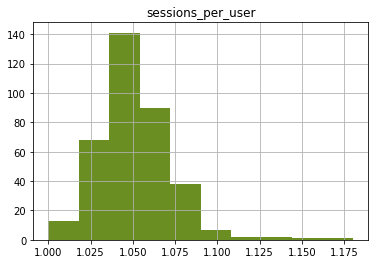

In [24]:
sessions_per_user_touch.hist('sessions_per_user', color="olivedrab");

В среднем, пользователи обоих типов устройств совершают по одной сессии в день.

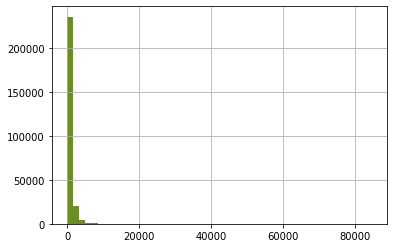

In [25]:
# длительность одной сессии пользователей desktop-устройств:
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

visits.query('device == "desktop"')['session_duration_sec'].hist(color="olivedrab", bins=50);

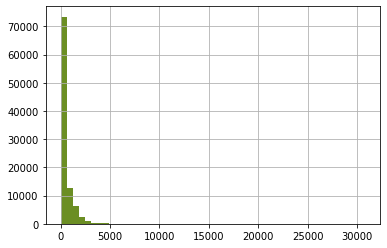

In [26]:
visits.query('device == "touch"')['session_duration_sec'].hist(color="olivedrab", bins=50);

In [27]:
# средняя продолжительность сессии пользователей desktop-устройств:
int(visits.query('device == "desktop"')['session_duration_sec'].mode())

60

In [28]:
# средняя продолжительность сессии пользователей touch-устройств:
int(visits.query('device == "touch"')['session_duration_sec'].mode())

60

Средняя продолжительность сессии пользователей обоих типов устройств составляет 60 секунд.

Рассмотрим как часто люди возвращаются:

 - по месяцам

In [29]:
# по месяцам
# фиксируем месяц первого посещения:
first_visit = visits.groupby(['uid'])['session_date'].min()
first_visit.name = 'first_visit_date'
visits = visits.join(first_visit,on='uid')
visits['visit_date'] = visits['start_ts'].astype('datetime64[M]')
visits['first_visit_date'] = visits['first_visit_date'].astype('datetime64[M]') 

In [30]:
# считаем месяцы жизни:
visits['cohort_lifetime'] = visits['visit_date'] - visits['first_visit_date']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype(int)

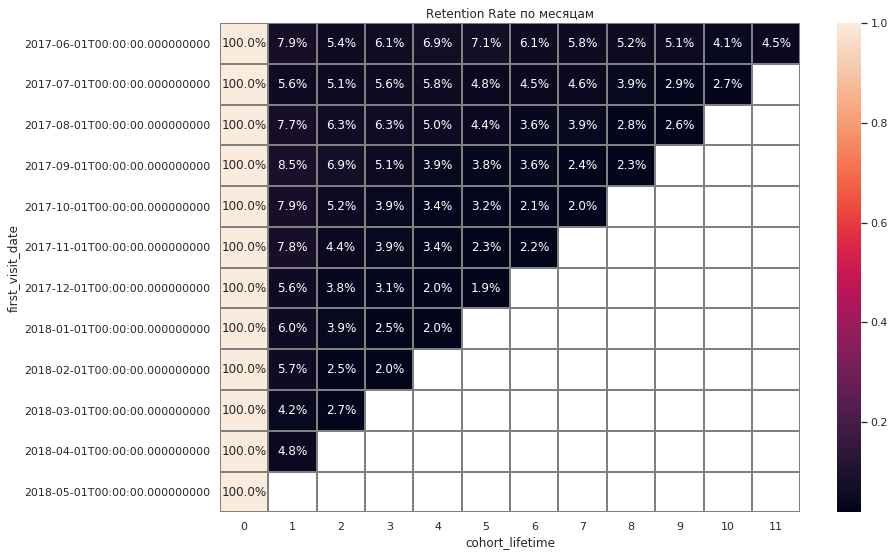

In [31]:
# формируем таблицу для подсчета Retention Rate по месяцам
cohorts = visits.groupby(['first_visit_date','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_visit_date','uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})
cohorts = cohorts.merge(initial_users_count,on='first_visit_date')
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']
retention_pivot_by_first_visit = cohorts.pivot_table(index='first_visit_date',columns='cohort_lifetime',values='retention',aggfunc='sum')
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Retention Rate по месяцам')
sns.heatmap(retention_pivot_by_first_visit, annot=True, fmt='.1%', linewidths=1, linecolor='gray');

Пользователи когорты июня 2017 года в большем количестве случаев, чем все остальные, возвращаются на сайт. Даже через 11 месяцев 4,5% пользователей этой когорты посещают сайт. Пользователи когорты декабря 2017 года практически не возвращаются на сайт, и через 5 месяцев удержание этой когорты составляет всего 1,9%.

 - по источникам привлечения пользователей:

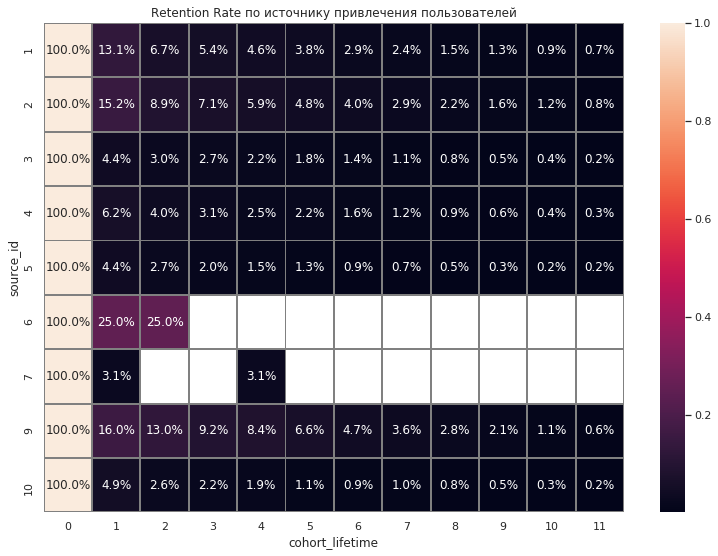

In [32]:
# формируем таблицу для расчета Retention Rate по источникам привлечения пользователей:
cohorts = visits.groupby(['source_id','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['source_id','uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})
cohorts = cohorts.merge(initial_users_count,on='source_id')
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']
retention_pivot_by_source = cohorts.pivot_table(index='source_id',columns='cohort_lifetime',values='retention',aggfunc='sum')
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Retention Rate по источнику привлечения пользователей')
sns.heatmap(retention_pivot_by_source, annot=True, fmt='.1%', linewidths=1, linecolor='gray');

Самые жизнеспособные источники привлечения пользователей - 1,2 и 9. Их Retention Rate в первый месяц составляет от 13% до 16%. И затем на протяжении года пользователи из этих источников продолжают пользоваться сервисом. Пользователи из 6 и 7 источников привлечения наименее постоянные. После второго месяца посещения пользователи источника 6 больше не возвращаются.

 - по устройствам:

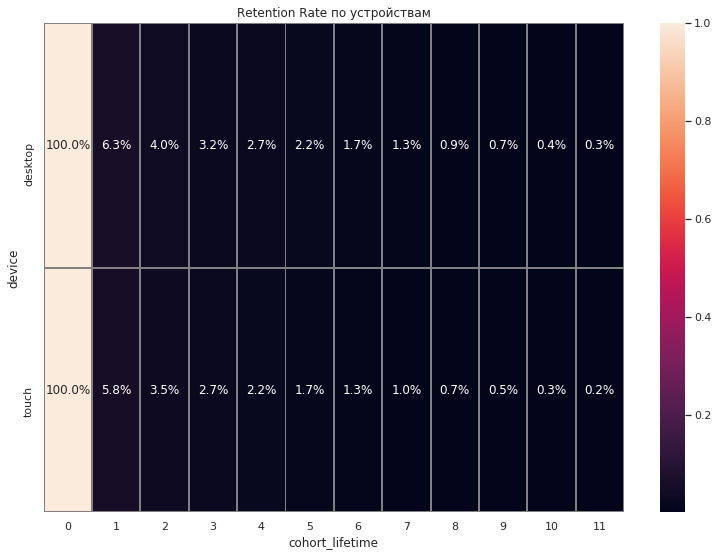

In [33]:
# формируем таблицу для расчета Retention Rate по устройствам:
cohorts = visits.groupby(['device','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['device','uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})
cohorts = cohorts.merge(initial_users_count,on='device')
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']
retention_pivot_by_device = cohorts.pivot_table(index='device',columns='cohort_lifetime',values='retention',aggfunc='sum')
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Retention Rate по устройствам')
sns.heatmap(retention_pivot_by_device, annot=True, fmt='.1%', linewidths=1, linecolor='gray');

Пользователи desktop-версии сайта возвращаются чаще, чем пользователи touch-версии. Возможно desktop-версия удобнее, чем touch.

#### <font color=olivedrab>Продажи / Маркетинг</font> 

In [34]:
orders['purchase_date'] = orders['buy_ts'].dt.date
orders['purchase_year'] = orders['buy_ts'].astype('datetime64[Y]')
orders['purchase_month'] = orders['buy_ts'].astype('datetime64[M]')
orders['purchase_week'] = orders['buy_ts'].astype('datetime64[W]')

In [35]:
orders_visits = orders.merge(visits, on = 'uid', how = 'inner')

Посчитаем количество покупок за период:

In [36]:
# количество покупок за день по устройствам:
(
    orders_visits[(orders_visits['buy_ts'] >= orders_visits['start_ts']) & (orders_visits['buy_ts'] <= orders_visits['end_ts'])]
    .pivot_table(index = 'purchase_date', columns = 'device', values = 'buy_ts', aggfunc='count')
).describe()    

device,desktop,touch
count,363.000000,363.000000
mean,82.468320,16.501377
std,44.763417,9.555125
min,8.000000,2.000000
25%,52.000000,10.000000
50%,78.000000,16.000000
75%,104.000000,22.000000
max,455.000000,79.000000


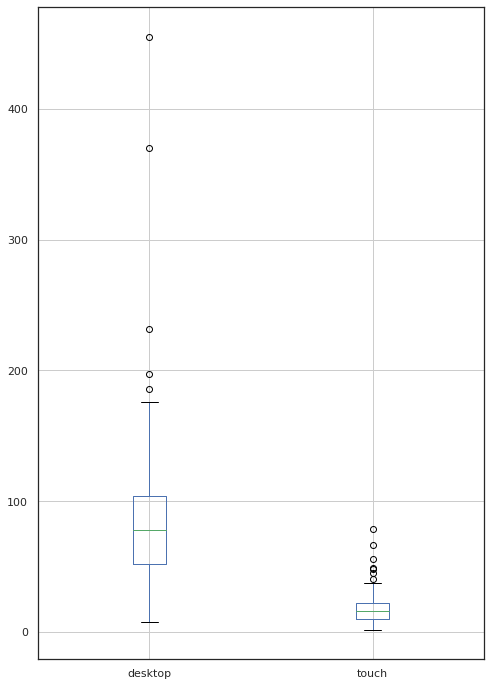

In [37]:
(
orders_visits[(orders_visits['buy_ts'] >= orders_visits['start_ts']) & (orders_visits['buy_ts'] <= orders_visits['end_ts'])]
      .pivot_table(index = 'purchase_date', columns = 'device', values = 'buy_ts', aggfunc='count').boxplot(figsize = (8, 12))
);

In [38]:
(
orders_visits[(orders_visits['buy_ts'] >= orders_visits['start_ts']) & (orders_visits['buy_ts'] <= orders_visits['end_ts'])]
      .pivot_table(index = 'purchase_date', columns = 'device', values = 'buy_ts', aggfunc='count')
      .query('desktop == "455"')
)

device,desktop,touch
purchase_date,,
2017-11-24,455,79


В типичный день количество покупок варьируется от 52 до 104 для пользователей desktop-версии и от 10 до 22 - для пользователей touch-версии. Максимальное количество покупок пользователей desktop-версии сервиса - 455 зафиксировано 24 ноября 2017 года, touch-версии - 79 в эту же дату.

In [39]:
# количество покупок за неделю по устройствам:
(
    orders_visits[(orders_visits['buy_ts'] >= orders_visits['start_ts']) & (orders_visits['buy_ts'] <= orders_visits['end_ts'])]
    .pivot_table(index = 'purchase_week', columns = 'device', values = 'buy_ts', aggfunc='count').reset_index()
).describe()

device,desktop,touch
count,53.000000,53.000000
mean,564.830189,113.018868
std,228.544368,47.059901
min,189.000000,33.000000
25%,373.000000,73.000000
50%,567.000000,114.000000
75%,743.000000,143.000000
max,1199.000000,223.000000


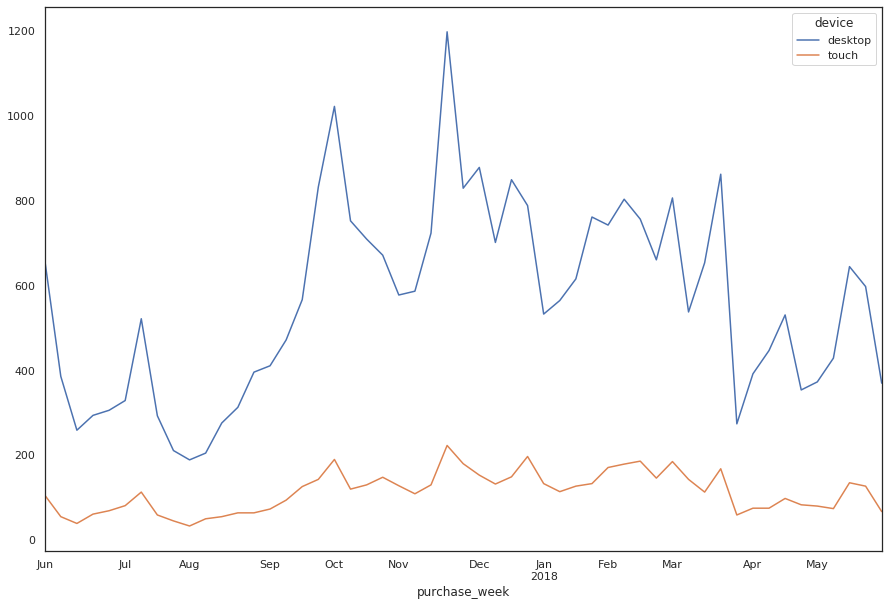

In [40]:
(
orders_visits[(orders_visits['buy_ts'] >= orders_visits['start_ts']) & (orders_visits['buy_ts'] <= orders_visits['end_ts'])]
      .pivot_table(index = 'purchase_week', columns = 'device', values = 'buy_ts', aggfunc='count').reset_index()
      .plot(x = 'purchase_week', figsize=(15, 10))
);

In [41]:
(
orders_visits[(orders_visits['buy_ts'] >= orders_visits['start_ts']) & (orders_visits['buy_ts'] <= orders_visits['end_ts'])]
      .pivot_table(index = 'purchase_week', columns = 'device', values = 'buy_ts', aggfunc='count').reset_index()
      .query('desktop == "1199"')
)

device,purchase_week,desktop,touch
25,2017-11-23,1199,223


В типичную неделю совершается от 373 до 743 покупок пользователями desktop-версии сервиса и от 73 до 143 покупок пользователями touch-версии сервиса. Максимальное количество покупок зафиксировано в 25 неделю периода и составляет 1 199 - пользователями desktop-версии и 223 - touch-версии.

In [42]:
# количество покупок за месяц по устройствам:
(
    orders_visits[(orders_visits['buy_ts'] >= orders_visits['start_ts']) & (orders_visits['buy_ts'] <= orders_visits['end_ts'])]
    .pivot_table(index = 'purchase_month', columns = 'device', values = 'buy_ts', aggfunc='count').reset_index()
).describe()

device,desktop,touch
count,12.000000,12.000000
mean,2494.666667,499.166667
std,842.194788,171.603578
min,1116.000000,222.000000
25%,1830.500000,343.000000
50%,2605.000000,551.500000
75%,3048.250000,638.000000
max,3671.000000,697.000000


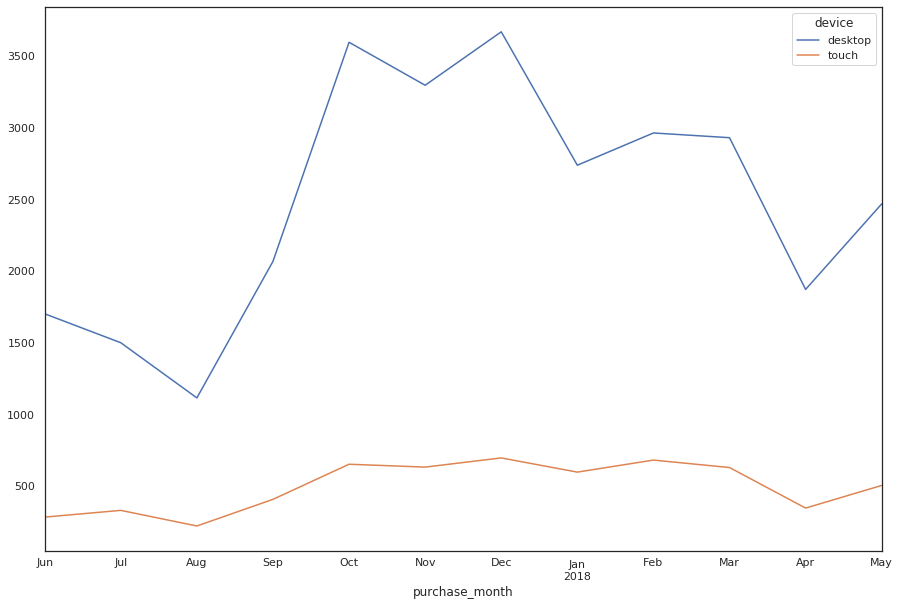

In [43]:
(
orders_visits[(orders_visits['buy_ts'] >= orders_visits['start_ts']) & (orders_visits['buy_ts'] <= orders_visits['end_ts'])]
      .pivot_table(index = 'purchase_month', columns = 'device', values = 'buy_ts', aggfunc='count').reset_index()
      .plot(x = 'purchase_month', figsize=(15, 10))
);

In [44]:
(
orders_visits[(orders_visits['buy_ts'] >= orders_visits['start_ts']) & (orders_visits['buy_ts'] <= orders_visits['end_ts'])]
      .pivot_table(index = 'purchase_month', columns = 'device', values = 'buy_ts', aggfunc='count').reset_index()
      .query('desktop == "3671"')
)

device,purchase_month,desktop,touch
6,2017-12-01,3671,697


Пользователями desktop-версии сервиса обычно совершается от 1 703 до 2 965 покупок, touch-версии - от 343 до 638. Максимальное количество покупок приходится на декабрь.

In [45]:
# количество покупок за день по источникам привлечения клиентов:
(
    orders_visits[(orders_visits['buy_ts'] >= orders_visits['start_ts']) & (orders_visits['buy_ts'] <= orders_visits['end_ts'])]
    .pivot_table(index = 'purchase_date', columns = 'source_id', values = 'buy_ts', aggfunc='count').reset_index()
).describe()    

source_id,1,2,3,4,5,7,9,10
count,361.000000,362.000000,363.000000,363.000000,363.000000,1.0,280.000000,313.000000
mean,14.531856,13.005525,21.608815,24.049587,20.451791,1.0,3.007143,3.613419
std,10.831267,11.099898,12.440405,12.864048,9.322033,NaN,4.285503,3.763107
min,1.000000,1.000000,1.000000,1.000000,2.000000,1.0,1.000000,1.000000
25%,8.000000,8.000000,13.000000,14.000000,14.000000,1.0,1.000000,1.000000
50%,13.000000,11.000000,20.000000,23.000000,19.000000,1.0,2.000000,3.000000
75%,18.000000,17.000000,28.000000,32.000000,26.500000,1.0,3.000000,5.000000
max,139.000000,163.000000,110.000000,97.000000,56.000000,1.0,49.000000,38.000000


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


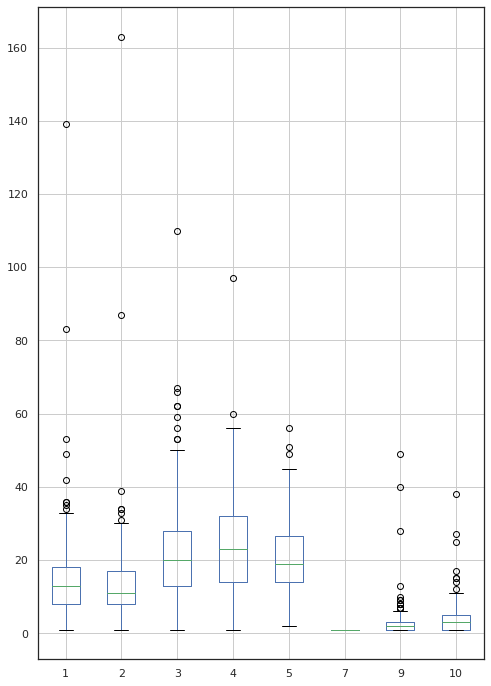

In [46]:
(
orders_visits[(orders_visits['buy_ts'] >= orders_visits['start_ts']) & (orders_visits['buy_ts'] <= orders_visits['end_ts'])]
      .pivot_table(index = 'purchase_date', columns = 'source_id', values = 'buy_ts', aggfunc='count')
      .boxplot(figsize = (8, 12))
);

В среднем пользователи, привлеченные 3, 4 и 5 источниками, совершают в день больше покупок, чем остальные. Из источника 7 только 1 пользователь за исследуемый период совершил покупку.

In [47]:
# количество покупок за неделю по источникам привлечения клиентов:
(
    orders_visits[(orders_visits['buy_ts'] >= orders_visits['start_ts']) & (orders_visits['buy_ts'] <= orders_visits['end_ts'])]
    .pivot_table(index = 'purchase_week', columns = 'source_id', values = 'buy_ts', aggfunc='count').reset_index()
).describe()    

source_id,1,2,3,4,5,7,9,10
count,53.000000,53.000000,53.00000,53.000000,53.000000,1.0,53.000000,53.000000
mean,98.981132,88.830189,148.00000,164.716981,140.075472,1.0,15.886792,21.339623
std,47.538847,39.250054,64.35867,75.325544,51.640342,NaN,14.214917,13.547556
min,31.000000,25.000000,48.00000,45.000000,42.000000,1.0,3.000000,4.000000
25%,64.000000,48.000000,92.00000,103.000000,104.000000,1.0,9.000000,12.000000
50%,98.000000,91.000000,154.00000,155.000000,138.000000,1.0,12.000000,19.000000
75%,124.000000,114.000000,185.00000,218.000000,176.000000,1.0,19.000000,28.000000
max,290.000000,201.000000,314.00000,324.000000,257.000000,1.0,91.000000,73.000000


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


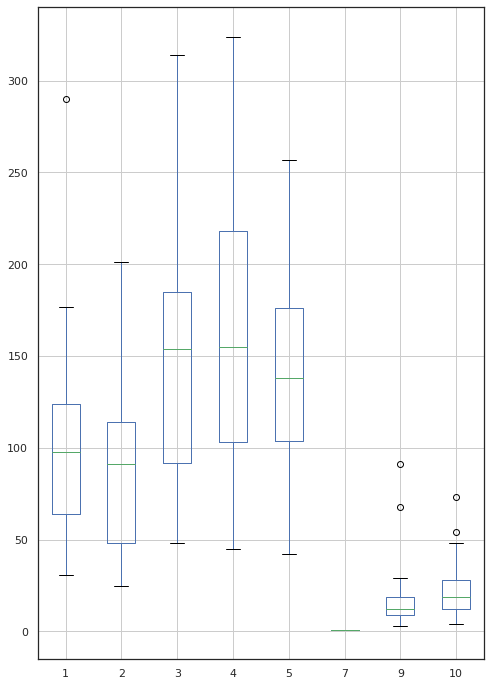

In [48]:
(
orders_visits[(orders_visits['buy_ts'] >= orders_visits['start_ts']) & (orders_visits['buy_ts'] <= orders_visits['end_ts'])]
      .pivot_table(index = 'purchase_week', columns = 'source_id', values = 'buy_ts', aggfunc='count').reset_index()
      .boxplot(figsize = (8, 12))
);

За неделю складывается аналогичная ситуация.

In [49]:
# количество покупок за месяц по источникам привлечения клиентов:
(
    orders_visits[(orders_visits['buy_ts'] >= orders_visits['start_ts']) & (orders_visits['buy_ts'] <= orders_visits['end_ts'])]
    .pivot_table(index = 'purchase_month', columns = 'source_id', values = 'buy_ts', aggfunc='count').reset_index()
).describe()    

source_id,1,2,3,4,5,7,9,10
count,12.000000,12.000000,12.000000,12.000000,12.000000,1.0,12.000000,12.000000
mean,437.166667,392.333333,653.666667,727.500000,618.666667,1.0,70.166667,94.250000
std,154.362521,142.508905,222.141778,297.667753,176.637962,NaN,35.011254,40.961456
min,181.000000,151.000000,274.000000,301.000000,346.000000,1.0,31.000000,38.000000
25%,323.250000,279.500000,519.250000,478.750000,468.000000,1.0,45.000000,66.000000
50%,457.000000,435.500000,656.500000,764.000000,654.500000,1.0,60.000000,92.000000
75%,541.750000,491.500000,847.500000,947.250000,692.750000,1.0,82.500000,113.750000
max,689.000000,605.000000,977.000000,1195.000000,979.000000,1.0,150.000000,181.000000


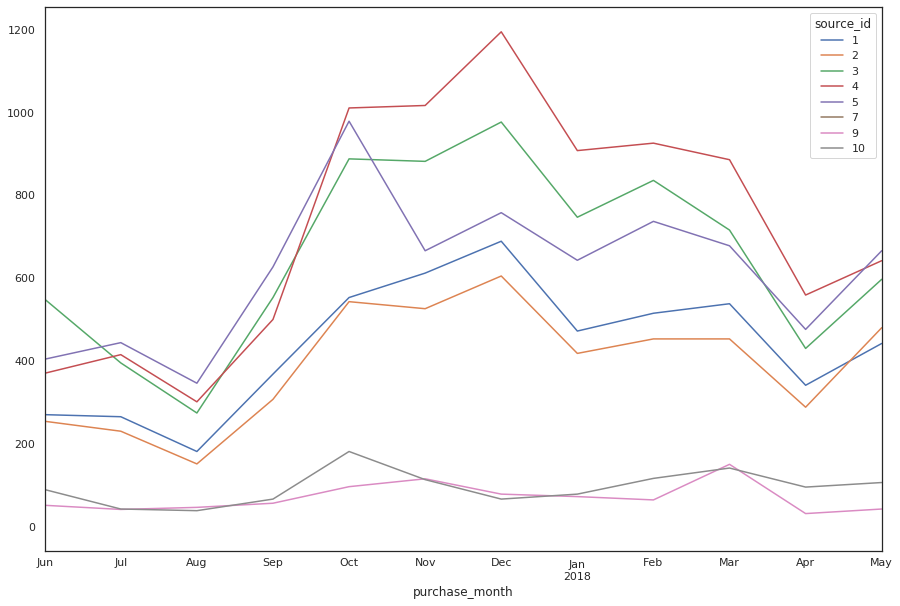

In [50]:
(
orders_visits[(orders_visits['buy_ts'] >= orders_visits['start_ts']) & (orders_visits['buy_ts'] <= orders_visits['end_ts'])]
      .pivot_table(index = 'purchase_month', columns = 'source_id', values = 'buy_ts', aggfunc='count').reset_index()
      .plot(x = 'purchase_month', figsize=(15, 10))
);

Так же за месяц, наиболее активными покупателями являются пользователи, пришедшие из 3, 4 и 5 источников. Декабрь является самым активным для покупок месяцем.

Рассчитаем средний чек .

In [51]:
# средний чек по устройствам:
average_revenue_by_devices = (
    orders_visits[(orders_visits['buy_ts'] >= orders_visits['start_ts']) & (orders_visits['buy_ts'] <= orders_visits['end_ts'])]
    .pivot_table(index = 'purchase_month', columns = 'device', values = ['revenue', 'uid'], aggfunc={'revenue' : 'sum',
                                                                                                    'uid' : 'nunique'})
    )
average_revenue_by_devices.columns = ['sum_desktop_revenue', 'sum_touch_revenue', 'count_desk_users', 'count_touch_users']
average_revenue_by_devices['average_desktop_revenue'] = average_revenue_by_devices['sum_desktop_revenue'] / average_revenue_by_devices['count_desk_users']
average_revenue_by_devices['average_touch_revenue'] = average_revenue_by_devices['sum_touch_revenue'] / average_revenue_by_devices['count_touch_users']
average_revenue_by_devices = average_revenue_by_devices[['average_desktop_revenue', 'average_touch_revenue']]
average_revenue_by_devices.describe()

,average_desktop_revenue,average_touch_revenue
count,12.000000,12.000000
mean,5.394093,4.245481
std,0.565315,0.739703
min,4.477105,3.210221
25%,5.113905,3.628964
50%,5.242976,4.072435
75%,5.854935,4.835467
max,6.425902,5.303862


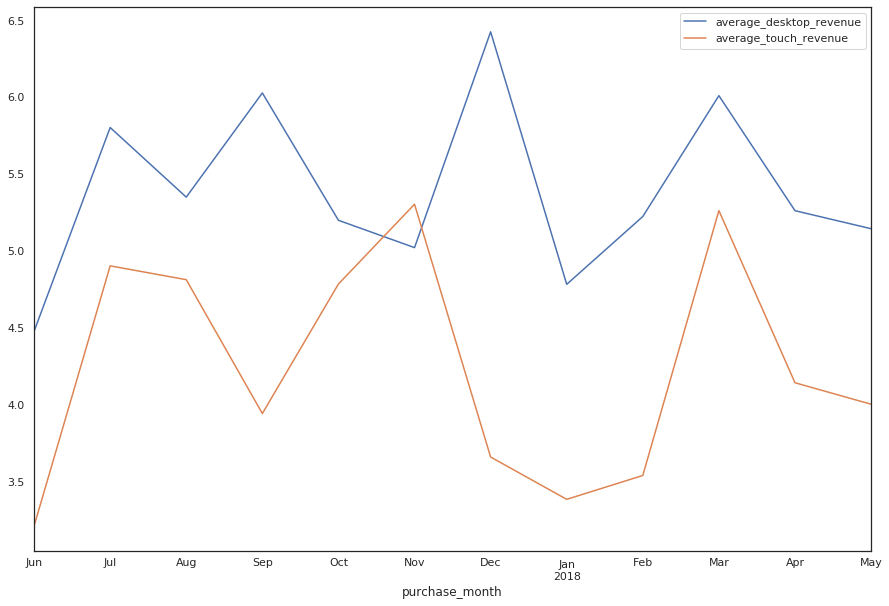

In [52]:
average_revenue_by_devices.plot(figsize = (15, 10));

Средний чек пользователей desktop-версии сервиса варьируется от 5.02 у.е. до 5.8 у.е. Средний чек пользователей touch-версии находится в пределах от 3,21 у.е. до 4,84 у.е.

In [53]:
# средний чек по источникам привлечения:
average_revenue_by_source = (
    orders_visits[(orders_visits['buy_ts'] >= orders_visits['start_ts']) & (orders_visits['buy_ts'] <= orders_visits['end_ts'])]
    .pivot_table(index = 'purchase_month', columns = 'source_id', values = ['revenue', 'uid'], aggfunc={'revenue' : 'sum',
                                                                                                    'uid' : 'nunique'})
    )
average_revenue_by_source.columns = ['sum_revenue_1', 'sum_revenue_2', 'sum_revenue_3', 'sum_revenue_4', 'sum_revenue_5',
                                     'sum_revenue_7', 'sum_revenue_9', 'sum_revenue_10', 'count_users_1', 'count_users_2',
                                     'count_users_3', 'count_users_4', 'count_users_5', 'count_users_7', 'count_users_9',
                                     'count_users_10']
average_revenue_by_source['average_revenue_1'] = (average_revenue_by_source['sum_revenue_1'] /
                                                  average_revenue_by_source['count_users_1'])
average_revenue_by_source['average_revenue_2'] = (average_revenue_by_source['sum_revenue_2'] /
                                                  average_revenue_by_source['count_users_2'])
average_revenue_by_source['average_revenue_3'] = (average_revenue_by_source['sum_revenue_3'] /
                                                  average_revenue_by_source['count_users_3'])
average_revenue_by_source['average_revenue_4'] = (average_revenue_by_source['sum_revenue_4'] /
                                                  average_revenue_by_source['count_users_4'])
average_revenue_by_source['average_revenue_5'] = (average_revenue_by_source['sum_revenue_5'] /
                                                  average_revenue_by_source['count_users_5'])
average_revenue_by_source['average_revenue_7'] = (average_revenue_by_source['sum_revenue_7'] /
                                                  average_revenue_by_source['count_users_7'])
average_revenue_by_source['average_revenue_9'] = (average_revenue_by_source['sum_revenue_9'] /
                                                  average_revenue_by_source['count_users_9'])
average_revenue_by_source['average_revenue_10'] = (average_revenue_by_source['sum_revenue_10'] /
                                                   average_revenue_by_source['count_users_10'])
average_revenue_by_source = average_revenue_by_source[['average_revenue_1', 'average_revenue_2', 'average_revenue_3',
                                                       'average_revenue_4', 'average_revenue_5', 'average_revenue_7',
                                                       'average_revenue_9', 'average_revenue_10']]
average_revenue_by_source.describe()

,average_revenue_1,average_revenue_2,average_revenue_3,average_revenue_4,average_revenue_5,average_revenue_7,average_revenue_9,average_revenue_10
count,12.000000,12.000000,12.000000,12.000000,12.000000,1.00,12.000000,12.000000
mean,6.257250,7.790465,4.038632,4.189958,5.033977,1.22,3.708040,2.921338
std,0.911485,2.959537,0.624909,0.469269,0.690199,NaN,1.275288,0.801489
min,4.996798,5.361579,3.096199,3.617454,4.161752,1.22,2.413382,2.037093
25%,5.337724,5.982016,3.664392,3.815736,4.659079,1.22,2.854886,2.439651
50%,6.275272,6.737167,3.894929,4.182479,4.815823,1.22,3.276028,2.734462
75%,6.926128,8.170909,4.437080,4.366100,5.113613,1.22,4.278387,3.246079
max,7.700963,16.092438,5.068244,5.175398,6.490000,1.22,7.103000,4.843514


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


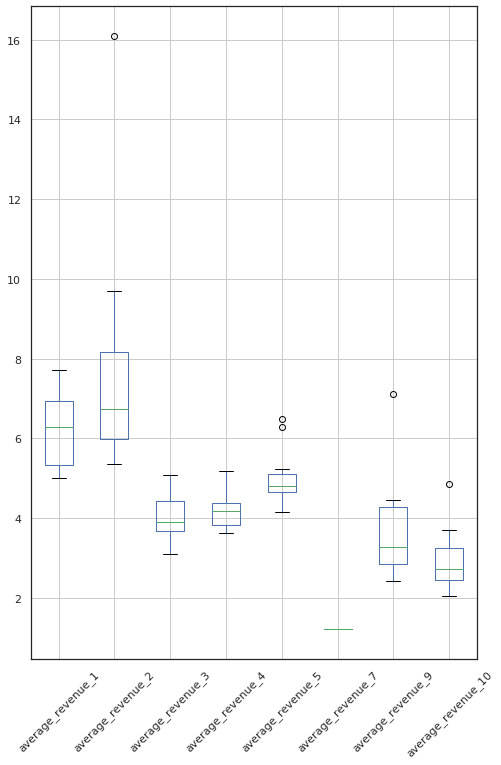

In [54]:
average_revenue_by_source.boxplot(figsize = (8, 12), rot = 45);

Второй источник привлечения пользователей приносит сервису пользователей, которые платят больше чем все остальные. Так же первый источник привлекает платящих пользователей.

 Посчитаем сколько денег потратили.

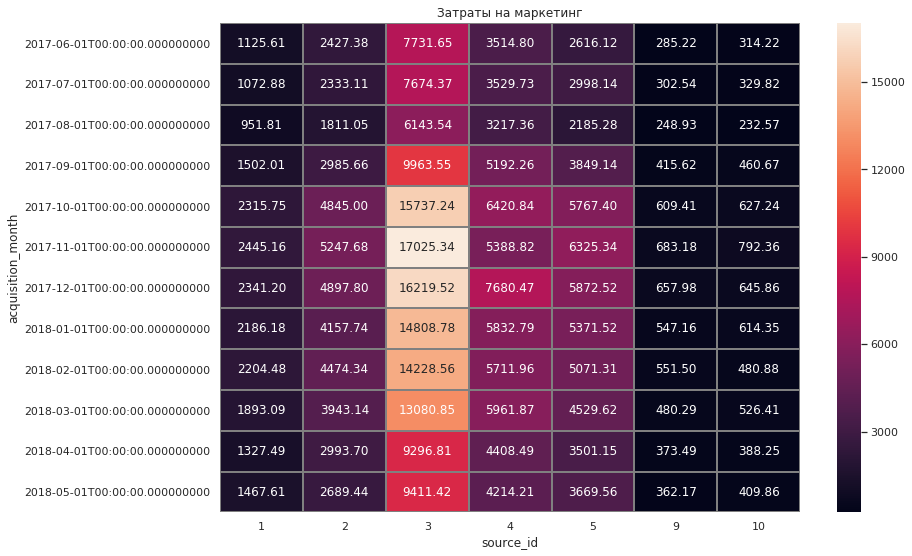

In [55]:
all_costs = costs.copy()
all_costs['acquisition_month'] = all_costs['acquisition_date'].astype('datetime64[M]')
all_costs.pivot_table(index='acquisition_month',columns='source_id',values='costs',aggfunc='sum')
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Затраты на маркетинг')
sns.heatmap(all_costs.pivot_table(index='acquisition_month',columns='source_id',values='costs',aggfunc='sum'),
            annot=True,  fmt='.2f',linewidths=1, linecolor='gray');

Больше всего затрат на маркетинг относится на 3 и 4 источники привлечения клиентов, и в большей степени затраты приходятся на осенне-зимний период.

Рассчитаем сколько денег приносят пользователи (ltv), сколько стоило привлечение одного покупателя (cac) и насколько окупились расходы.

In [56]:
# построим профили пользователей
users = (visits.sort_values(by = ['uid', 'start_ts'])
.groupby('uid')
.agg({'start_ts' : 'first', 'source_id' : 'first', 'device' : 'first'})
.rename(columns = {'start_ts' : 'acquisition_ts'}))
users['acquisition_date'] = users['acquisition_ts'].dt.date
users['acquisition_year'] = users['acquisition_ts'].astype('datetime64[Y]')
users['acquisition_month'] = users['acquisition_ts'].astype('datetime64[M]')
users['acquisition_week'] = users['acquisition_ts'].astype('datetime64[W]')
users = (users.reset_index()
              .set_index(['source_id', 'acquisition_date'])
              .join(costs.set_index(['source_id', 'acquisition_date']), how = 'left'))
# добавляем стоимость привлечения пользователя
user_cost = (users.groupby(['source_id', 'acquisition_date'])
                  .agg({'device': 'count', 'costs': 'max'})
                  .rename(columns = {'device': 'users'}))
user_cost['acquisition_cost'] = user_cost['costs'] / user_cost['users']
users = users.join(user_cost[['acquisition_cost']], how = 'left').reset_index()
users = users.set_index('uid')[['acquisition_ts', 'acquisition_date', 'acquisition_year', 'acquisition_month',
                                'acquisition_week', 'source_id', 'device', 'acquisition_cost']]

# определение пользователя как плательщика или нет
users = users.join(orders.groupby('uid').agg({'buy_ts' : 'min'}).rename(columns = {'buy_ts' : 'first_purchase_dt'}), how = 'left')
users['payer'] = ~users['first_purchase_dt'].isna()

In [57]:
# расчет ltv, cac по месяцам привлечения:
cohorts = (users.groupby(['acquisition_month'])
          .agg({'payer': 'sum', 'acquisition_cost': 'sum'})
          .rename(columns = {'payer': 'cohort_size'}))
cohorts['cac'] = cohorts['acquisition_cost'] / cohorts['cohort_size']
ltv = orders.set_index('uid').join(users, how = 'left')
ltv['age_month'] = ((ltv['purchase_month'] - ltv['acquisition_month']) / np.timedelta64(1, 'M')).round().astype('int')
ltv = ltv.groupby(['acquisition_month'] + ['age_month']).agg({'revenue' : 'sum'})
ltv = pd.pivot_table(ltv, index = ['acquisition_month'], columns = 'age_month', values = 'revenue', aggfunc = 'sum')
ltv['sum_ltv'] = ltv.sum(axis = 1)
ltv = cohorts[['cohort_size']].join(ltv)
ltv = ltv.div(ltv['cohort_size'], axis = 0).drop(columns = ['cohort_size'])
ltv
cohorts[['cohort_size', 'cac']].join(ltv.fillna(''))

,cohort_size,cac,0,1,2,3,4,5,6,7,8,9,10,11,sum_ltv
acquisition_month,,,,,,,,,,,,,,,
2017-06-01,2923.0,6.163189,3.269754,0.911591,0.501091,1.32812,1.34813,0.966295,1.19396,0.776876,0.79299,1.19112,0.754023,0.659531,13.693483
2017-07-01,2458.0,7.416928,4.017449,0.430952,0.451139,0.399902,0.344585,0.324687,0.239219,0.313385,0.29476,0.240452,0.190057,,7.246587
2017-08-01,1721.0,8.593359,3.622783,0.5795,0.581842,0.549802,0.47068,0.309646,0.282772,0.724131,0.48265,0.218315,,,7.822121
2017-09-01,3058.0,7.966109,4.040942,1.2101,0.690199,3.41365,0.421347,0.624608,0.316167,0.160687,0.136877,,,,11.014572
2017-10-01,4678.0,7.764617,3.925250,0.814414,0.283673,0.226176,0.223059,0.21851,0.123752,0.140209,,,,,5.955043
2017-11-01,4262.0,8.894388,3.878881,0.625899,0.315075,0.321335,0.260145,0.166032,0.163914,,,,,,5.731281
2017-12-01,4074.0,9.402560,4.137703,0.426861,1.03051,1.25769,0.357774,0.43744,,,,,,,7.647975
2018-01-01,3119.0,10.746560,3.397567,0.625745,0.37344,0.0980699,0.169115,,,,,,,,4.663937
2018-02-01,3186.0,10.266073,3.613506,0.622869,0.208158,0.282803,,,,,,,,,4.727335


In [58]:
# расчет ROMI по месяцам привлечения пользователей

cohorts = (users.groupby(['acquisition_month'])
          .agg({'payer': 'sum', 'acquisition_cost': 'sum'})
          .rename(columns = {'payer': 'cohort_size'}))
cohorts['cac'] = cohorts['acquisition_cost'] / cohorts['cohort_size']
cohorts
romi = orders.set_index('uid').join(users, how = 'left')
romi['age_month'] = ((romi['purchase_month'] - romi['acquisition_month']) / np.timedelta64(1, 'M')).round().astype('int')
romi = romi.query('age_month < 6')
romi = romi.groupby(['acquisition_month'] + ['age_month']).agg({'revenue' : 'sum'})
romi = cohorts[['cohort_size', 'cac']].join(romi)
romi['romi'] = ((romi['revenue'] / romi['cohort_size']) / romi['cac'])
romi = pd.pivot_table(romi, index = ['acquisition_month'], columns = 'age_month', values = 'romi', aggfunc = 'sum')
romi['sum_romi, %'] = (romi.sum(axis = 1) - 1)*100
romi.fillna('').reset_index().query('acquisition_month < "2017-12-01"')


age_month,acquisition_month,0,1,2,3,4,5,"sum_romi, %"
0,2017-06-01,0.530530,0.147909,0.0813039,0.215492,0.218739,0.156785,35.075881
1,2017-07-01,0.541659,0.0581038,0.0608256,0.0539175,0.0464593,0.0437764,-19.525792
2,2017-08-01,0.421579,0.0674358,0.0677083,0.0639799,0.0547725,0.0360331,-28.849083
3,2017-09-01,0.507267,0.151906,0.086642,0.428521,0.0528925,0.0784081,30.563629
4,2017-10-01,0.505530,0.104888,0.036534,0.029129,0.0287276,0.0281418,-26.704931
5,2017-11-01,0.436104,0.0703701,0.035424,0.0361278,0.0292483,0.0186671,-37.405838


Больше всего расходов на маркетинг (cac) из расчета на одного пользователя было потрачено на привлечение новых пользователей с января по апрель 2018 года. На конец исследуемого периода пользователи этих месяцев так и не окупились. Их суммарный ltv из расчета на одного пользователя меньше cac. А пользователи июня 2017 года, при наименьших за исследуемый период cac окупились уже на 4 месяц пользования сервисом. Если смотреть на представленную таблицу, окупились только пользователи, пришедшие в 
- июне 2017 года (окупились на 4 месяц), ROMI составил 1.22, то есть инвестор получил 122% прибыли с вложенных денег;
- сентябре 2017 года (окупились на 3 месяц), ROMI составил 0.38, то есть инвестор получил 38% прибыли с вложенных денег.

А на пользвователей ноября 2017 года было потрачено больше всех маркетинговых расходов, которые за полгода так и не окупились.

In [59]:
# расчет ltv, cac по источникам привлечения клиентов:
cohorts = (users.groupby(['source_id'])
          .agg({'payer': 'sum', 'acquisition_cost': 'sum'})
          .rename(columns = {'payer': 'count_users'}))
cohorts['cac'] = cohorts['acquisition_cost'] / cohorts['count_users']
ltv = orders.set_index('uid').join(users, how = 'left')
ltv['age_month'] = ((ltv['purchase_month'] - ltv['acquisition_month']) / np.timedelta64(1, 'M')).round().astype('int')
ltv = ltv.groupby(['source_id'] + ['age_month']).agg({'revenue' : 'sum'})
ltv = pd.pivot_table(ltv, index = ['source_id'], columns = 'age_month', values = 'revenue', aggfunc = 'sum')
ltv = ltv.cumsum(axis = 1)
ltv = cohorts[['count_users']].join(ltv)
ltv = ltv.div(ltv['count_users'], axis = 0).drop(columns = ['count_users'])
cohorts[['count_users', 'cac']].join(ltv.fillna(''))

,count_users,cac,0,1,2,3,4,5,6,7,8,9,10,11
source_id,,,,,,,,,,,,,,
1,2899.0,7.186364,5.01103,5.91271,6.53207,7.47546,8.0591,8.44345,8.76577,9.52745,9.95958,10.2595,10.5436,10.7246
2,3506.0,12.209367,5.10707,6.83526,8.55977,10.4129,11.3238,12.0295,12.3777,12.6007,12.8151,13.0869,13.2739,13.3838
3,10473.0,13.493901,3.60076,4.16547,4.40178,4.61541,4.80527,4.93693,5.03932,5.09469,5.14371,5.17189,5.19062,5.20493
4,10295.0,5.932356,3.63794,4.07052,4.27698,4.47911,4.65041,4.85918,5.06127,5.13064,5.22295,5.35563,5.43283,5.50689
5,6931.0,7.467378,4.15272,4.64651,4.93725,6.50599,6.75947,7.07028,7.23654,7.37004,7.44842,7.56141,7.5809,7.59256
6,0.0,NaN,,,,,,,,,,,,
7,1.0,0.000000,1.22,,,,,,,,,,,
9,1088.0,5.013254,2.1825,2.76248,3.28825,3.75573,4.17557,4.38342,4.63808,4.82143,5.07512,5.22578,5.2793,5.29357
10,1329.0,4.380075,2.67454,2.90242,2.9982,3.05593,3.18546,3.24597,3.29983,3.31937,3.32259,3.3359,3.34178,3.34863


In [60]:
# расчет ROMI по источнику привлечения пользователей
cohorts = (users.groupby(['source_id'])
          .agg({'payer': 'sum', 'acquisition_cost': 'sum'})
          .rename(columns = {'payer': 'count_users'}))
cohorts['cac'] = cohorts['acquisition_cost'] / cohorts['count_users']
romi = orders.set_index('uid').join(users, how = 'left')

romi['age_month'] = ((romi['purchase_month'] - romi['acquisition_month']) / np.timedelta64(1, 'M')).round().astype('int')
romi = romi.groupby(['source_id'] + ['age_month']).agg({'revenue' : 'sum'})
romi = cohorts[['count_users', 'cac']].join(romi)
romi['romi'] = ((romi['revenue'] / romi['count_users']) / romi['cac'])
romi = pd.pivot_table(romi, index = ['source_id'], columns = 'age_month', values = 'romi', aggfunc = 'sum')
romi = romi.cumsum(axis = 1)
romi.fillna('')

age_month,0,1,2,3,4,5,6,7,8,9,10,11
source_id,,,,,,,,,,,,
1,0.697297,0.822769,0.908954,1.04023,1.12144,1.17493,1.21978,1.32577,1.3859,1.42763,1.46717,1.49235
2,0.418291,0.559837,0.701083,0.852863,0.927469,0.98527,1.01379,1.03205,1.04961,1.07187,1.08719,1.09619
3,0.266843,0.308693,0.326205,0.342036,0.356107,0.365864,0.373452,0.377555,0.381188,0.383276,0.384664,0.385725
4,0.613237,0.686157,0.720958,0.75503,0.783905,0.819097,0.853164,0.864857,0.880417,0.902784,0.915797,0.92828
5,0.556115,0.622242,0.661176,0.871255,0.9052,0.946823,0.969087,0.986965,0.997461,1.01259,1.0152,1.01676
7,inf,,,,,,,,,,,
9,0.435346,0.551036,0.655912,0.749159,0.832906,0.874366,0.925163,0.961737,1.01234,1.04239,1.05307,1.05591
10,0.610616,0.662642,0.684509,0.697689,0.72726,0.741076,0.753372,0.757834,0.758569,0.761608,0.762951,0.764514


Самые высокие расходы на привлечение одного пользователя приходятся на третий источник привлечения пользователей (13.49 у.е.). При этом ежемесячный прирост доходов по этому источнику привлечения недостаточно большой и за исследуемый период затраты на привлечение пользователей по этому источнику не окупились. При аналогичных расходах во втором источнике привлечения клиентов (12.21 у.е.), они окупаются уже на шестой месяц. Расходы на привлечение одного пользователя на первый источник составляют 7.19 у.е., и окупаются они уже на третий месяц. Также, несмотря на сравнительно небольшие сас в 9 и 10 источниках привлечения (5.01 у.е. и 4.38 у.е. соответственно), эти источники практически не окупаются.

In [61]:
# расчет ltv, cac по устройствам :
cohorts = (users.groupby(['device'])
          .agg({'payer': 'sum', 'acquisition_cost': 'sum'})
          .rename(columns = {'payer': 'count_users'}))
cohorts['cac'] = cohorts['acquisition_cost'] / cohorts['count_users']
ltv = orders.set_index('uid').join(users, how = 'left')
ltv['age_month'] = ((ltv['purchase_month'] - ltv['acquisition_month']) / np.timedelta64(1, 'M')).round().astype('int')
ltv = ltv.groupby(['device'] + ['age_month']).agg({'revenue' : 'sum'})
ltv = pd.pivot_table(ltv, index = ['device'], columns = 'age_month', values = 'revenue', aggfunc = 'sum')
ltv = ltv.cumsum(axis = 1)
ltv = cohorts[['count_users']].join(ltv)
ltv = ltv.div(ltv['count_users'], axis = 0).drop(columns = ['count_users'])
cohorts[['count_users', 'cac']].join(ltv.fillna(''))

,count_users,cac,0,1,2,3,4,5,6,7,8,9,10,11
device,,,,,,,,,,,,,,
desktop,29210.0,8.047441,4.011143,4.642398,5.087855,5.888890,6.223265,6.510334,6.714005,6.859679,6.973683,7.094901,7.176592,7.234726
touch,7312.0,12.855680,3.438590,4.116656,4.409964,4.630186,4.801991,4.965036,5.082611,5.243920,5.375428,5.499554,5.538528,5.569944


In [62]:
# расчет ROMI по устройствам:
cohorts = (users.groupby(['device'])
          .agg({'payer': 'sum', 'acquisition_cost': 'sum'})
          .rename(columns = {'payer': 'count_users'}))
cohorts['cac'] = cohorts['acquisition_cost'] / cohorts['count_users']
romi = orders.set_index('uid').join(users, how = 'left')

romi['age_month'] = ((romi['purchase_month'] - romi['acquisition_month']) / np.timedelta64(1, 'M')).round().astype('int')
romi = romi.groupby(['device'] + ['age_month']).agg({'revenue' : 'sum'})
romi = cohorts[['count_users', 'cac']].join(romi)
romi['romi'] = ((romi['revenue'] / romi['count_users']) / romi['cac'])
romi = pd.pivot_table(romi, index = ['device'], columns = 'age_month', values = 'romi', aggfunc = 'sum')
romi = romi.cumsum(axis = 1)
romi.fillna('')

age_month,0,1,2,3,4,5,6,7,8,9,10,11
device,,,,,,,,,,,,
desktop,0.498437,0.576879,0.632233,0.731772,0.773322,0.808994,0.834303,0.852405,0.866571,0.881634,0.891786,0.899010
touch,0.267476,0.320221,0.343036,0.360167,0.373531,0.386213,0.395359,0.407907,0.418136,0.427792,0.430823,0.433267


In [63]:
orders['revenue'].sum()

252053.77999999997

### <font color=olive>Шаг 3. Общий вывод</font>

In [64]:
print("Суммарная прибыль по всем пользователям за исследуемый период {:.2f}".format(orders['revenue'].sum()), "у.е.,")
print("суммарные расходы - {:.2f}".format(costs['costs'].sum()), "у.е.,")
print("превышение расходов над прибылью составило {:.2f}".format(costs['costs'].sum() - orders['revenue'].sum()), "у.е.")

Суммарная прибыль по всем пользователям за исследуемый период 252053.78 у.е.,
суммарные расходы - 329131.62 у.е.,
превышение расходов над прибылью составило 77077.84 у.е.


Проведен анализ посещений, прибыли и маркетинговых расходов сервиса Яндекс.Афиша за период с июня 2017 года по май 2018 года.


Наиболее действенный вариант привлечения пользователей – четвертый, меньше всего посещений обеспечивают шестой и седьмой варианты. При этом, в среднем пользователей touch-устройств в 2,5 раза меньше, чем пользователей desktop-устройств.  В среднем пользователи совершают по одной сессии в день, которая длится 60 секунд.


Пользователи июня 2017 года в большем количестве случаев, чем все остальные возвращаются на сайт. Даже через 11 месяцев 4,5% пользователей этой когорты посещают сайт. Самые жизнеспособные источники привлечения пользователей - 1,2 и 9. Их Retention Rate в первый месяц составляет от 13% до 16%. И затем на протяжении года пользователи из этих источников продолжают пользоваться сервисом. Пользователи desktop-версии сайта возвращаются чаще, чем пользователи touch-версии.


Самым активным месяцем как для посещений, так и для покупок является декабрь.


В среднем, пользователи, привлеченные 3, 4 и 5 источниками, совершают в день больше покупок, чем остальные. Из источника 7 только 1 пользователь за исследуемый период совершил покупку. Пользователи desktop-версии сервиса делают покупок больше, чем пользователи touch-версии сервиса.

Пользователи desktop-версии сервиса совершают более дорогие покупки нежели пользователи touch-версии. Средний чек первых варьируется от 5.02 у.е. до 5.8 у.е., вторых - от 3,21 у.е. до 4,84 у.е.
 
Второй источник привлечения пользователей приносит сервису пользователей, которые платят больше чем все остальные. Так же первый источник привлекает платящих пользователей.


Самые высокие расходы на привлечение одного пользователя приходятся на третий источник привлечения пользователей (13.49 у.е.). При этом ежемесячный прирост доходов по этому источнику привлечения недостаточно большой и за исследуемый период затраты на привлечение пользователей по этому источнику не окупились. При аналогичных расходах во втором источнике привлечения клиентов (12.21 у.е.), они окупаются уже на шестой месяц. Расходы на привлечение одного пользователя на первый источник составляют 7.19 у.е., и окупаются они уже на третий месяц. Также, несмотря на сравнительно небольшие сас в 9 и 10 источниках привлечения (5.01 у.е. и 4.38 у.е. соответственно), эти источники практически не окупаются. 

Так же стоит обратить внимание на удобство touch-версии сервиса. Количество посещений и покупок с этой версии значительно меньше этих действий desktop-версии.
